## **StackOverflow VS-Code Extension ::** 
## **Tag Prediction Model**
### Group 11

## Loading Processed Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import spacy
import matplotlib.pyplot as plt
from wordcloud import WordCloud
EN = spacy.load('en_core_web_sm')

In [ ]:
data = pd.read_csv('/content/gdrive/My Drive/Stackoverflow_VS_extension/Preprocessed_data.csv')
print(data.shape)
data.head()

(147059, 8)


,original_title,post_corpus,question_content,question_url,tags,overall_scores,answers_content,processed_title
0,Using 'in' to match an attribute of Python obj...,using match attribute python objects array nt ...,using match attribute python objects array nt ...,https://stackoverflow.com/questions/683,python|arrays|iteration,0.011301,Using a list comprehension would build a tempo...,using match attribute python objects array
1,Python version of PHP's stripslashes,python version php stripslashes wrote piece co...,python version php stripslashes wrote piece co...,https://stackoverflow.com/questions/13454,python|string|escaping,0.001115,Python has a built-in escape() function analog...,python version php stripslashes
2,Unicode vs UTF-8 confusion in Python / Django?,unicode vs utf8 confusion python django stumbl...,unicode vs utf8 confusion python django stumbl...,https://stackoverflow.com/questions/22149,python|django|unicode,0.006997,From Wikipedia on UTF-8:,unicode vs utf8 confusion python django
3,Using Django time/date widgets in custom form,using django time date widgets custom form use...,using django time date widgets custom form use...,https://stackoverflow.com/questions/38601,python|django,0.041431,"Starting in Django 1.2 RC1, if you're using th...",using django time date widgets custom form
4,Can parallel traversals be done in MATLAB just...,parallel traversals done matlab python using f...,parallel traversals done matlab python using f...,https://stackoverflow.com/questions/49307,python|arrays|matlab|for-loop,0.002837,should be for example:,parallel traversals done matlab python


## Training Word Embeddings Model
We use gensim to train our word embedding model

In [ ]:

import gensim

W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

documents = [_text.split() for _text in np.array(data.post_corpus)]  

In [ ]:


w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)
w2v_model.build_vocab(documents)
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)
w2v_model.save('/content/gdrive/My Drive/Stackoverflow_VS_extension/SO_word2vec_embeddings.bin')


In [ ]:

w2v_model = gensim.models.word2vec.Word2Vec.load('/content/gdrive/My Drive/Stackoverflow_VS_extension/SO_word2vec_embeddings.bin')

In [ ]:

print('Terms most similar to "dataframe"')
print(w2v_model.wv.most_similar("dataframe"))
print('Terms most similar to "matplotlib"')
print(w2v_model.wv.most_similar("matplotlib"))
print('Terms most similar to "list"')
print(w2v_model.wv.most_similar("list"))
print('Terms most similar to "scipy"')
print(w2v_model.wv.most_similar("scipy"))


Terms most similar to "dataframe"
[('column', 0.7256514430046082), ('dataframes', 0.6733587384223938), ('columns', 0.6662962436676025), ('pandas', 0.6136767268180847), ('series', 0.6034044623374939), ('frame', 0.5821376442909241), ('rows', 0.5803079605102539), ('df', 0.5779855251312256), ('dataset', 0.5477191209793091), ('groupby', 0.5331104397773743)]
Terms most similar to "matplotlib"
[('matlibplot', 0.5427229404449463), ('matplotlibs', 0.5059307813644409), ('pyplot', 0.4861833453178406), ('plot', 0.47908711433410645), ('pylab', 0.4675483703613281), ('plotting', 0.4614831805229187), ('mplot3d', 0.4611230194568634), ('matplolib', 0.45407480001449585), ('plots', 0.45263585448265076), ('matplotlibpyplot', 0.4367786943912506)]
Terms most similar to "list"
[('lists', 0.730812668800354), ('dictionary', 0.6977571249008179), ('tuple', 0.5968090295791626), ('tuples', 0.5925501585006714), ('array', 0.5868478417396545), ('string', 0.5647833347320557), ('sublist', 0.5439674854278564), ('sublists

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


### Choosing 500 most frequent tags
These acts as ground truth for one-hot encoding

In [ ]:

data.tags = data.tags.apply(lambda x: x.split('|'))
tag_freq_dict = {}
for tags in data.tags:
    for tag in tags:
        if tag not in tag_freq_dict:
            tag_freq_dict[tag] = 0
        else:
            tag_freq_dict[tag] += 1

In [ ]:

tags_to_use = 500
tag_freq_dict_sorted = dict(sorted(tag_freq_dict.items(), key=lambda x: x[1], reverse=True))
final_tags = list(tag_freq_dict_sorted.keys())[:tags_to_use]
len(final_tags)

500

In [ ]:

final_tag_data = []
for tags in data.tags:
    temp = []
    for tag in tags:
        if tag in final_tags:
            temp.append(tag)
    final_tag_data.append(temp)

## One-hot encode tags for each question in our database

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
tag_encoder = MultiLabelBinarizer()
tags_encoded = tag_encoder.fit_transform(final_tag_data)
tags_encoded.shape

(147059, 500)

# Training Model

### Dataset splitting

In [ ]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(data.processed_title), tags_encoded, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (117647,)
X_test shape: (29412,)
y_train shape: (117647, 500)
y_test shape: (29412, 500)


### Tokenizing

In [ ]:

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from keras.utils.np_utils import to_categorical

MAX_SEQUENCE_LENGTH = 300

EMBEDDING_DIM = 300

tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.post_corpus)
word_index = tokenizer.word_index   
vocab_size = len(word_index)
print('Found %s unique tokens.' % len(word_index))


import pickle
with open('/content/gdrive/My Drive/Stackoverflow_VS_extension/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


Found 471299 unique tokens.


In [ ]:

import pickle
with open('/content/gdrive/My Drive/Stackoverflow_VS_extension/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
word_index = tokenizer.word_index
vocab_size = len(word_index)
print('Found %s unique tokens.' % len(word_index))

Found 471299 unique tokens.


In [ ]:
## Add padding
X_train_padded = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train_padded, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_train_padded.shape)

Shape of data tensor: (117647, 300)


In [ ]:

embedding_matrix = np.zeros((vocab_size+1, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(471300, 300)


## Model training using GRU .

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          141390000 
_________________________________________________________________
gru (GRU)                    (None, 500)               1203000   
_________________________________________________________________
batch_normalization (BatchNo (None, 500)               2000      
_________________________________________________________________
dense (Dense)                (None, 150)               75150     
_________________________________________________________________
batch_normalization_1 (Batch (None, 150)               600       
_________________________________________________________________
dense_1 (Dense)              (None, 500)               75500     
Total params: 142,746,250
Trainable params: 1,354,950
Non-trainable params: 141,391,300
__________________________________

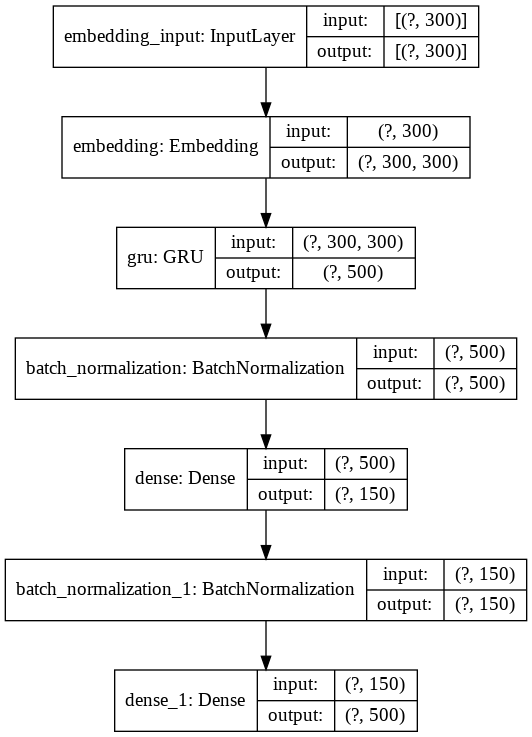

In [ ]:

from tensorflow.keras.layers import Dense, Embedding,GRU
from tensorflow.keras.layers import BatchNormalization
from datetime import datetime
from time import time
from keras.utils.vis_utils import plot_model


model = Sequential()
model.add(Embedding(vocab_size+1, W2V_SIZE, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model.add(GRU(500, activation='relu',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dense(150,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(500, activation='sigmoid'))
model.summary()

model.compile(loss="binary_crossentropy",
              optimizer="adam")

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
BATCH_SIZE = 1024
history = model.fit(X_train_padded, y_train, batch_size=BATCH_SIZE, epochs=10, validation_split=0.1, verbose=1)

Epoch 1/10
104/104 [==============================] - 98s 943ms/step - loss: 0.4892 - val_loss: 0.1206
Epoch 2/10
104/104 [==============================] - 100s 963ms/step - loss: 0.0559 - val_loss: 0.0287
Epoch 3/10
104/104 [==============================] - 100s 965ms/step - loss: 0.0217 - val_loss: 0.0187
Epoch 4/10
104/104 [==============================] - 100s 964ms/step - loss: 0.0165 - val_loss: 0.0159
Epoch 5/10
104/104 [==============================] - 100s 963ms/step - loss: 0.0144 - val_loss: 0.0144
Epoch 6/10
104/104 [==============================] - 100s 966ms/step - loss: 0.0132 - val_loss: 0.0134
Epoch 7/10
104/104 [==============================] - 100s 965ms/step - loss: 0.0123 - val_loss: 0.0126
Epoch 8/10
104/104 [==============================] - 100s 963ms/step - loss: 0.0116 - val_loss: 0.0122
Epoch 9/10
104/104 [==============================] - 100s 961ms/step - loss: 0.0110 - val_loss: 0.0119
Epoch 10/10
104/104 [==============================] - 100s 959ms

In [ ]:
model.save_weights('/content/gdrive/My Drive/Stackoverflow_VS_extension/Tag_predictor_weights.h5')

In [ ]:
# Function to calculate average cosine similarity for tags of test dataset
from sklearn.metrics.pairwise import cosine_similarity
def calculate_accuracy(y_test, yhat):
    cosine_similarities_tags = 0
    for i in range(len(y_test)):
        predicted_tags = yhat[i]
        predicted_tags = np.array(predicted_tags)[np.newaxis]
        y_test_i = np.array(y_test[i])[np.newaxis]
        cosine_similarities_tags += pd.Series(cosine_similarity(predicted_tags, y_test_i)[0])
    cosine_similarities_tags /= len(y_test)
    return cosine_similarities_tags

In [ ]:

X_test_padded = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_padded, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of test data tensor:', X_test_padded.shape)
yhat = model.predict(X_test_padded)

Shape of test data tensor: (29412, 300)


Average Cosine Similarity with the test dataset

In [ ]:

acc = calculate_accuracy(y_test, yhat)
print("GRU accuracy: %.3f" % acc)

>0.778


## Model training using LSTM.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          141390000 
_________________________________________________________________
lstm (LSTM)                  (None, 500)               1602000   
_________________________________________________________________
batch_normalization_2 (Batch (None, 500)               2000      
_________________________________________________________________
dense_2 (Dense)              (None, 150)               75150     
_________________________________________________________________
batch_normalization_3 (Batch (None, 150)               600       
_________________________________________________________________
dense_3 (Dense)              (None, 500)               75500     
Total params: 143,145,250
Trainable params: 1,753,950
Non-trainable params: 141,391,300
________________________________

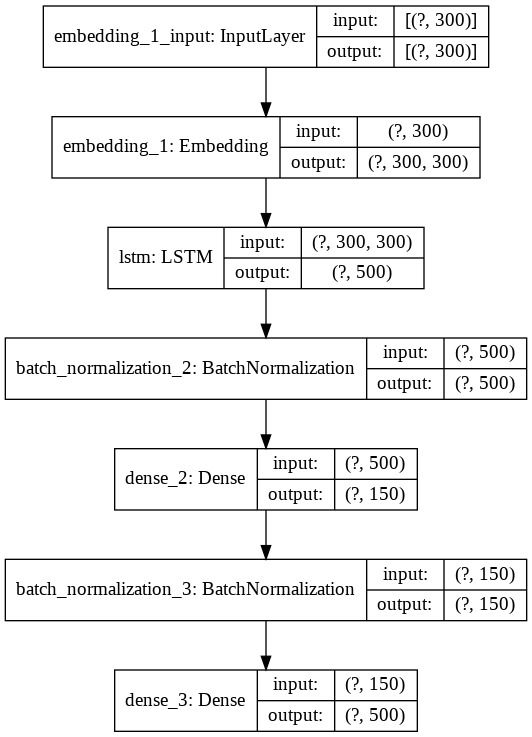

In [ ]:

from tensorflow.keras.layers import LSTM

model2 = Sequential()
model2.add(Embedding(vocab_size+1, W2V_SIZE, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model2.add(LSTM(500, activation='relu',kernel_initializer='he_normal'))
model2.add(BatchNormalization())
model2.add(Dense(150,activation='relu'))
model2.add(BatchNormalization())
model2.add(Dense(500, activation='sigmoid'))
model2.summary()

model2.compile(loss="binary_crossentropy",
              optimizer="adam")

plot_model(model2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
BATCH_SIZE = 1024
history2 = model2.fit(X_train_padded, y_train, batch_size=BATCH_SIZE, epochs=10, validation_split=0.1, verbose=1)

Epoch 1/10
104/104 [==============================] - 119s 1s/step - loss: 0.4951 - val_loss: 0.1544
Epoch 2/10
104/104 [==============================] - 116s 1s/step - loss: 0.0582 - val_loss: 0.0315
Epoch 3/10
104/104 [==============================] - 117s 1s/step - loss: 0.0222 - val_loss: 0.0217
Epoch 4/10
104/104 [==============================] - 110s 1s/step - loss: 0.0220 - val_loss: 0.0235
Epoch 5/10
104/104 [==============================] - 109s 1s/step - loss: 0.0214 - val_loss: 0.0215
Epoch 6/10
104/104 [==============================] - 109s 1s/step - loss: 0.0208 - val_loss: 0.0207
Epoch 7/10
104/104 [==============================] - 108s 1s/step - loss: 0.0205 - val_loss: 0.0204
Epoch 8/10
104/104 [==============================] - 108s 1s/step - loss: 0.0204 - val_loss: 0.0203
Epoch 9/10
104/104 [==============================] - 109s 1s/step - loss: 0.0203 - val_loss: 0.0202
Epoch 10/10
104/104 [==============================] - 108s 1s/step - loss: 0.0203 - val_lo

Average Cosine Similarity with the test dataset

In [ ]:

yhat2 = model2.predict(X_test_padded)
acc = calculate_accuracy(y_test, yhat2)
print("LSTM accuracy: %.3f" % acc)

LSTM accuracy: 0.604


## Result Visualization

Since GRU Models gives better accuracy (average cosine similarity), we chose it to be our prediction model

58/58 [==============================] - 12s 209ms/step - loss: 0.0120
LOSS: 0.011963573284447193


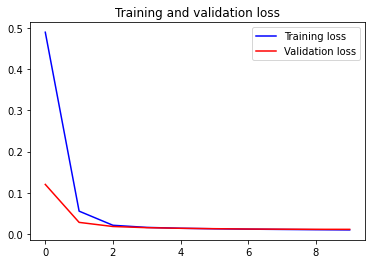

In [ ]:

import matplotlib.pyplot as plt
X_test_padded = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_padded, maxlen=MAX_SEQUENCE_LENGTH)
score = model.evaluate(X_test_padded, y_test, batch_size=512)
print("LOSS:",score)

loss = history.history["loss"]
val_loss = history.history['val_loss']
 
epochs = range(len(loss))
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [ ]:

def predict_tags(text):

    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=MAX_SEQUENCE_LENGTH)

    prediction = model.predict([x_test])[0]
    indices = prediction.argsort()[-5:]
    for i,_ in enumerate(prediction):
        if i in indices:
            prediction[i] = 1
        else:
            prediction[i] = 0
    tags = tag_encoder.inverse_transform(np.array([prediction]))
    return tags

In [ ]:
test_idx = np.random.randint(len(X_test), size=5)

for idx in test_idx:
    test_case = idx
    print('Test Case: ' + str(X_test[test_case]))
    print('-'*100)
    print('Predicted: ' + str(predict_tags(X_test[test_case])))
    print('Ground Truth: ' + str(tag_encoder.inverse_transform(np.array([y_test[test_case]]))))
    print('\n')

Test Case: ldamodel random_state parameter recognized gensim
----------------------------------------------------------------------------------------------------
Predicted: [('numpy', 'python', 'python-2.7', 'python-3.x', 'random')]
Ground Truth: [('numpy', 'python-3.x')]


Test Case: flask code displays hello world code work inside main thanks
----------------------------------------------------------------------------------------------------
Predicted: [('flask', 'html', 'jinja2', 'python', 'python-3.x')]
Ground Truth: [('flask', 'python')]


Test Case: python sqlite3 never returns inner join 28 milion rows
----------------------------------------------------------------------------------------------------
Predicted: [('python', 'python-3.x', 'sql', 'sqlite', 'tkinter')]
Ground Truth: [('python', 'python-2.7', 'sqlite')]


Test Case: tensorflow optimizer negative feedback
----------------------------------------------------------------------------------------------------
Predicted: [